# Diffusion-TS Tutorial

## Diffusion-TS: Interpretable Diffusion for General Time Series Generation

This notebook describes the user-guide of a time-series synthetic data generation application using Diffusion-TS framework.

## Necessary packages and functions call

In [2]:
import os
import torch
import numpy as np

from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

## Setting and Training

### Build dataset and settings

In [3]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/sines.yaml'
        self.save_dir = './toy_exp'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

Sampling sine-dataset: 100%|██████████| 10000/10000 [00:01<00:00, 8713.17it/s]


### Training models

In [4]:
trainer.train()

loss: 0.098974: 100%|██████████| 1000/1000 [00:51<00:00, 19.28it/s]

training complete


## Inference and Visualizations

### Sampling

In [5]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))
fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_sines.npy'), fake_data)

sampling loop time step: 100%|██████████| 500/500 [00:05<00:00, 85.23it/s]


### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

In [27]:
import numpy as np
ori_data = np.load("/home/rzhou/Projects/Diffusion-TS/OUTPUT/inD_multi_18-29_interval1500_v30_with0values/samples/inD_multi_18-29_interval1500_v30_with0values_norm_truth_1500_train.npy")
fake_data=np.load("/home/rzhou/Projects/Diffusion-TS/OUTPUT/inD_multi_18-29_interval1500_v30_with0values/ddpm_fake_inD_multi_18-29_interval1500_v30_with0values.npy")
print(ori_data)
print(ori_data.shape)
print(fake_data.shape)


[[[0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  ...
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]]

 [[0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  ...
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]]

 [[0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  ...
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]]

 ...

 [[0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  ...
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]]

 [[0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  ...
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]]

 [[0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  ...
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]
  [0. 1. 0. ... 1. 0. 1.]]]
(247, 1500

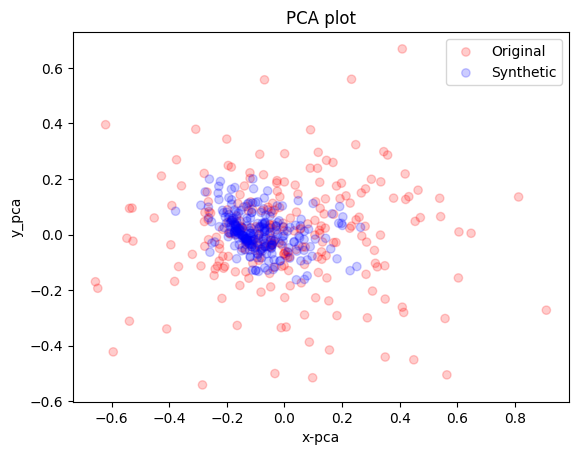

In [28]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])

/home/rzhou/miniconda3/envs/diffusion-ts/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/rzhou/miniconda3/envs/diffusion-ts/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 494 samples in 0.001s...
[t-SNE] Computed neighbors for 494 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 494 / 494
[t-SNE] Mean sigma: 0.100917
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.406479
[t-SNE] KL divergence after 300 iterations: 1.239648


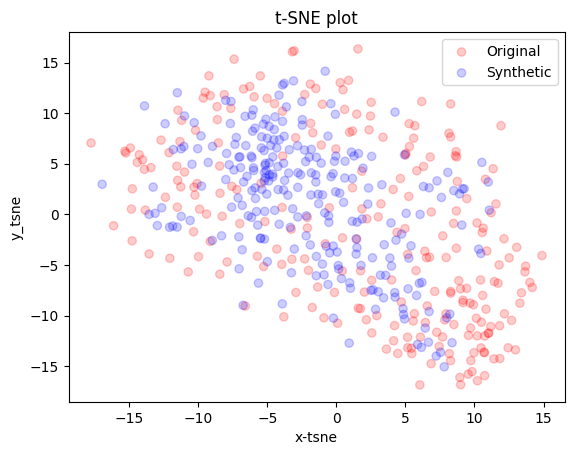

In [29]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])

/home/rzhou/Projects/Diffusion-TS/Utils/metric_utils.py:157: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/home/rzhou/Projects/Diffusion-TS/Utils/metric_utils.py:158: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad63727

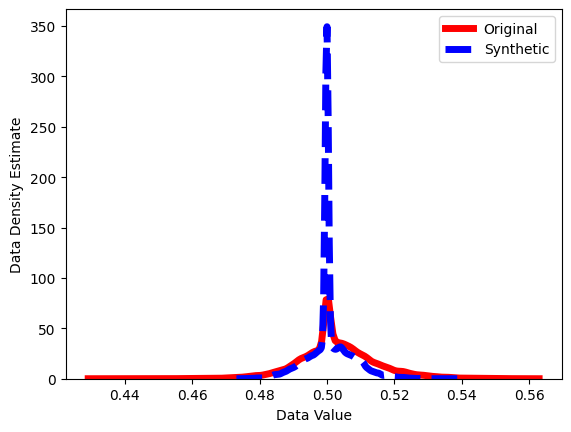

In [30]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])